In [ ]:
import math
import matplotlib.pyplot as plt 
import datetime as dt
from glob import glob

import lzma
import struct
import pandas as pd
import numpy as np
import requests

from lzma import LZMADecompressor, FORMAT_AUTO

from tqdm import tqdm
import time

# First Webscrape tick data from Dukascopy:

In [ ]:
symbol = 'EURUSD'

start=dt.datetime(2020, 1, 1)
end=dt.datetime(2020, 12, 31)

dates = pd.date_range(start, end, freq='B')

hour = ['{:0>2}'.format(n) for n in range(0,24)]
months = ['{:0>2}'.format(n) for n in range(0,12)]

raw_tick_data = [] 

for days in range(len(dates)):
    data = []

    for n in range(0,24):
       #url = f"https://www.dukascopy.com/datafeed/{symbol}/{year}/{month}/{day}/{hour}h_ticks.bi5"
        url = f"https://www.dukascopy.com/datafeed/{symbol}/{'{:0>2}'.format(dates[days].year)}/{'{:0>2}'.format(months[dates[days].month-1])}/{'{:0>2}'.format(dates[days].day)}/{hour[n]}h_ticks.bi5"

        res = requests.get(url , stream=True)

        rawdata = res.content

        decomp = LZMADecompressor(FORMAT_AUTO, None, None)
        decompresseddata = decomp.decompress(rawdata)

        one_hour_data = []

        for i in range(0, int(len(decompresseddata) / 20)):
            one_hour_data.append(struct.unpack('!IIIff', decompresseddata[i * 20: (i + 1) * 20]))


        time = [pd.Timestamp(year=dates[days].year, month=dates[days].month, day=dates[days].day, hour=n) + pd.Timedelta(z[0], 'ms') for z in one_hour_data]
        values = [(l[1], l[2], l[3], l[4]) for l in one_hour_data]
        ticks = [(time[k] , values[k][0], values[k][1], values[k][2], values[k][3]) for k in range(len(one_hour_data))]

        data.append(ticks)


    one_day_data = [element for sublist in data for element in sublist]

    df = pd.DataFrame(one_day_data, columns=['Date', 'Ask', 'Bid', 'Ask_Volume', 'Bid_Volume'])
    
    df['Ask'] = df['Ask'].map(lambda a: a / 100000.)
    df['Bid'] = df['Bid'].map(lambda a: a / 100000.)

    df.to_csv(f"{symbol}_{'{:0>2}'.format(dates[days].year)}-{'{:0>2}'.format(dates[days].month)}-{'{:0>2}'.format(dates[days].day)}.csv")

In [ ]:
daily_tick_data_files = sorted(glob("/content/{}_*.csv".format(symbol)))
daily_tick_data_files

['/content/EURUSD_2020-01-01.csv',
 '/content/EURUSD_2020-01-02.csv',
 '/content/EURUSD_2020-01-03.csv',
 '/content/EURUSD_2020-01-06.csv',
 '/content/EURUSD_2020-01-07.csv',
 '/content/EURUSD_2020-01-08.csv',
 '/content/EURUSD_2020-01-09.csv',
 '/content/EURUSD_2020-01-10.csv',
 '/content/EURUSD_2020-01-13.csv',
 '/content/EURUSD_2020-01-14.csv',
 '/content/EURUSD_2020-01-15.csv',
 '/content/EURUSD_2020-01-16.csv',
 '/content/EURUSD_2020-01-17.csv',
 '/content/EURUSD_2020-01-20.csv',
 '/content/EURUSD_2020-01-21.csv',
 '/content/EURUSD_2020-01-22.csv',
 '/content/EURUSD_2020-01-23.csv',
 '/content/EURUSD_2020-01-24.csv',
 '/content/EURUSD_2020-01-27.csv',
 '/content/EURUSD_2020-01-28.csv',
 '/content/EURUSD_2020-01-29.csv',
 '/content/EURUSD_2020-01-30.csv',
 '/content/EURUSD_2020-01-31.csv',
 '/content/EURUSD_2020-02-03.csv',
 '/content/EURUSD_2020-02-04.csv',
 '/content/EURUSD_2020-02-05.csv',
 '/content/EURUSD_2020-02-06.csv',
 '/content/EURUSD_2020-02-07.csv',
 '/content/EURUSD_20

In [ ]:
df = pd.concat((pd.read_csv(file).assign(filename=file)
            for file in daily_tick_data_files), ignore_index = False)

df = df.iloc[: , [1,2,3,4,5]]

df['Date'] = pd.to_datetime(df['Date'],format="%Y-%m-%d %H:%M:%S.%f")
df.set_index(df.Date, inplace=True)
df.drop(columns=["Date"], inplace=True)
df

,Ask,Bid,Ask_Volume,Bid_Volume
Date,,,,
2020-01-01 22:01:12.821,1.12160,1.12106,0.0937,0.75
2020-01-01 22:01:17.176,1.12160,1.12120,0.0937,0.75
2020-01-01 22:01:18.545,1.12160,1.12117,0.0937,0.75
2020-01-01 22:01:19.145,1.12161,1.12123,0.8400,0.75
2020-01-01 22:01:19.246,1.12161,1.12120,0.8400,0.75
...,...,...,...,...
2020-12-31 21:59:56.150,1.22177,1.22142,7.5000,0.75
2020-12-31 21:59:56.252,1.22177,1.22141,7.5000,0.75
2020-12-31 21:59:56.419,1.22178,1.22141,7.5000,1.50


# Tick data to 1 minute

In [ ]:
EURUSD = df['Bid'].resample("1min").ohlc()
EURUSD

,open,high,low,close
Date,,,,
2020-01-01 22:01:00,1.12106,1.12135,1.12106,1.12135
2020-01-01 22:02:00,1.12136,1.12139,1.12136,1.12139
2020-01-01 22:03:00,1.12135,1.12135,1.12120,1.12122
2020-01-01 22:04:00,1.12122,1.12125,1.12122,1.12125
2020-01-01 22:05:00,1.12125,1.12127,1.12125,1.12127
...,...,...,...,...
2020-12-31 21:55:00,1.22175,1.22180,1.22170,1.22174
2020-12-31 21:56:00,1.22176,1.22179,1.22160,1.22165
2020-12-31 21:57:00,1.22166,1.22167,1.22153,1.22164


In [ ]:
EURUSD.to_csv("EURUSD_2020.csv")

# Tick Data to 15 minutes

In [ ]:
EURUSD = df['Bid'].resample("15min").ohlc()
EURUSD

,open,high,low,close
Date,,,,
2020-01-01 22:00:00,1.12106,1.12139,1.12106,1.12127
2020-01-01 22:15:00,1.12127,1.12154,1.12127,1.12146
2020-01-01 22:30:00,1.12147,1.12156,1.12138,1.12154
2020-01-01 22:45:00,1.12155,1.12166,1.12143,1.12143
2020-01-01 23:00:00,1.12143,1.12218,1.12142,1.12202
...,...,...,...,...
2020-12-31 20:45:00,1.22159,1.22182,1.22130,1.22158
2020-12-31 21:00:00,1.22159,1.22279,1.22143,1.22266
2020-12-31 21:15:00,1.22264,1.22273,1.22192,1.22199


# Tick Data to 1 Hour

In [ ]:
EURUSD = df['Bid'].resample("1H").ohlc()
EURUSD

,open,high,low,close
Date,,,,
2020-01-01 22:00:00,1.12106,1.12166,1.12106,1.12143
2020-01-01 23:00:00,1.12143,1.12218,1.12142,1.12188
2020-01-02 00:00:00,1.12188,1.12190,1.12157,1.12183
2020-01-02 01:00:00,1.12182,1.12244,1.12180,1.12209
2020-01-02 02:00:00,1.12210,1.12245,1.12184,1.12222
...,...,...,...,...
2020-12-31 17:00:00,1.22298,1.22346,1.22217,1.22250
2020-12-31 18:00:00,1.22251,1.22279,1.22149,1.22166
2020-12-31 19:00:00,1.22166,1.22228,1.22091,1.22098


# Tick Data to Daily

In [ ]:
EURUSD = df['Bid'].resample("1D").ohlc()
EURUSD.dropna() #NaN's are weekends, that's why i dropped it

,open,high,low,close
Date,,,,
2020-01-01,1.12106,1.12218,1.12106,1.12188
2020-01-02,1.12188,1.12245,1.11635,1.11708
2020-01-03,1.11707,1.11798,1.11249,1.11548
2020-01-06,1.11603,1.12055,1.11571,1.11954
2020-01-07,1.11953,1.11970,1.11335,1.11540
...,...,...,...,...
2020-12-25,1.21816,1.22031,1.21709,1.21922
2020-12-28,1.22039,1.22502,1.21811,1.22196
2020-12-29,1.22196,1.22750,1.22193,1.22519


# Filtering by certain Hours

In [ ]:
df.between_time("09:00:00", "10:00:00")

,Ask,Bid,Ask_Volume,Bid_Volume
Date,,,,
2020-01-02 09:00:00.138,1.12120,1.12119,1.50,0.75
2020-01-02 09:00:00.239,1.12119,1.12118,4.50,0.75
2020-01-02 09:00:00.342,1.12118,1.12115,0.37,0.75
2020-01-02 09:00:00.444,1.12117,1.12114,0.37,1.87
2020-01-02 09:00:00.495,1.12119,1.12114,3.00,1.76
...,...,...,...,...
2020-12-31 09:59:56.400,1.22792,1.22788,1.87,0.75
2020-12-31 09:59:58.499,1.22791,1.22788,0.75,0.75
2020-12-31 09:59:59.550,1.22792,1.22790,1.50,0.82


# Filter the first Friday of each month (Non-Farm payrroll anouncement)

In [ ]:
DF = EURUSD.loc[(EURUSD.index.weekday==4) & (EURUSD.index.day<8)]
DF

,open,high,low,close
Date,,,,
2020-01-03,1.11707,1.11798,1.11249,1.11548
2020-02-07,1.09809,1.09849,1.09419,1.09438
2020-03-06,1.12224,1.13546,1.12112,1.12804
2020-04-03,1.08459,1.08553,1.07727,1.07955
2020-05-01,1.09447,1.10187,1.09344,1.09777
2020-06-05,1.13357,1.13836,1.12784,1.12911
2020-07-03,1.12373,1.12518,1.12192,1.12464
2020-08-07,1.18753,1.18818,1.17551,1.17862
2020-09-04,1.18413,1.18654,1.17809,1.18371


In [ ]:
DF = df.loc[(df.index.weekday==4) & (df.index.day<8)]
DF

,Ask,Bid,Ask_Volume,Bid_Volume
Date,,,,
2020-01-03 00:00:01.278,1.11711,1.11707,0.75,4.50
2020-01-03 00:00:01.387,1.11712,1.11707,3.94,3.75
2020-01-03 00:00:01.488,1.11712,1.11709,2.25,0.82
2020-01-03 00:00:01.540,1.11711,1.11707,0.37,3.45
2020-01-03 00:00:02.251,1.11711,1.11708,1.87,0.75
...,...,...,...,...
2020-12-04 21:59:59.164,1.21229,1.21198,0.37,7.50
2020-12-04 21:59:59.428,1.21229,1.21201,0.75,7.50
2020-12-04 21:59:59.602,1.21230,1.21201,0.37,7.50


In [ ]:
df['2020-05-01':'2020-09-30']

,Ask,Bid,Ask_Volume,Bid_Volume
Date,,,,
2020-05-01 00:00:00.096,1.09451,1.09447,0.10,0.75
2020-05-01 00:00:00.198,1.09451,1.09446,3.07,0.75
2020-05-01 00:00:00.501,1.09450,1.09446,0.10,3.75
2020-05-01 00:00:00.863,1.09450,1.09445,4.57,0.75
2020-05-01 00:00:00.965,1.09450,1.09446,3.07,0.75
...,...,...,...,...
2020-09-30 23:59:53.192,1.17234,1.17229,4.32,16.76
2020-09-30 23:59:53.406,1.17235,1.17229,4.51,16.76
2020-09-30 23:59:53.627,1.17233,1.17230,4.32,16.76


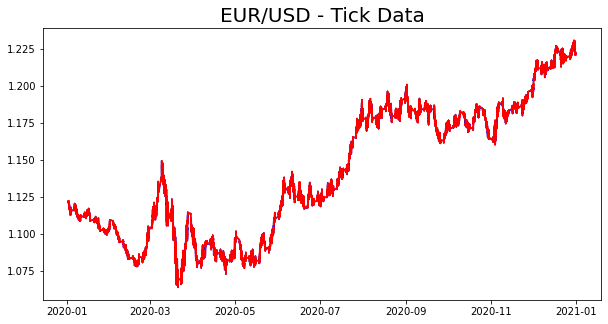

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df["Bid"], color='blue')
plt.plot(df["Ask"], color='red')

plt.title('EUR/USD - Tick Data', fontsize=20)
plt.show()

# Neural Network

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import os

In [ ]:
EURUSD.dropna(inplace=True)

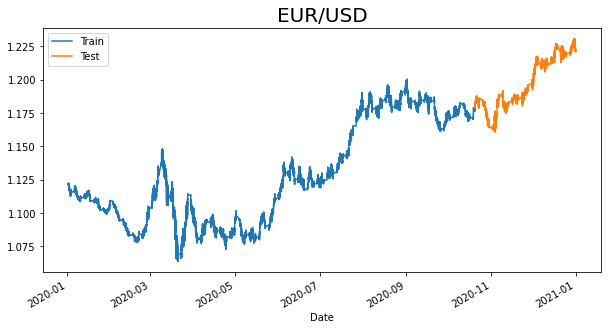

In [ ]:
plt.figure(figsize=(10,5))

plt.title('EUR/USD', fontsize=20)

size = int(len(EURUSD['close'])*0.80)
train_data = EURUSD['close'][:size]
test_data = EURUSD['close'][size:]

train_data.plot(legend=True)
test_data.plot(legend=True)
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:

sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(train_data.values.reshape(-1, 1))

In [ ]:
time_step = 60
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
   
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])


    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
#
# LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=32)

Epoch 1/20
9135/9135 [==============================] - 238s 26ms/step - loss: 0.0012
Epoch 2/20
9135/9135 [==============================] - 249s 27ms/step - loss: 4.1258e-05
Epoch 3/20
9135/9135 [==============================] - 263s 29ms/step - loss: 2.6917e-05
Epoch 4/20
9135/9135 [==============================] - 242s 26ms/step - loss: 2.0354e-05
Epoch 5/20
9135/9135 [==============================] - 242s 27ms/step - loss: 1.6597e-05
Epoch 6/20
9135/9135 [==============================] - 253s 28ms/step - loss: 1.4170e-05
Epoch 7/20
9135/9135 [==============================] - 253s 28ms/step - loss: 1.2613e-05
Epoch 8/20
9135/9135 [==============================] - 274s 30ms/step - loss: 1.1431e-05
Epoch 9/20
9135/9135 [==============================] - 283s 31ms/step - loss: 1.0314e-05
Epoch 10/20
9135/9135 [==============================] - 281s 31ms/step - loss: 9.5063e-06
Epoch 11/20
9135/9135 [==============================] - 267s 29ms/step - loss: 8.9130e-06
Epoch 12/20


In [ ]:
x_test = test_data.values.reshape(-1, 1)
x_test = sc.transform(x_test)

X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

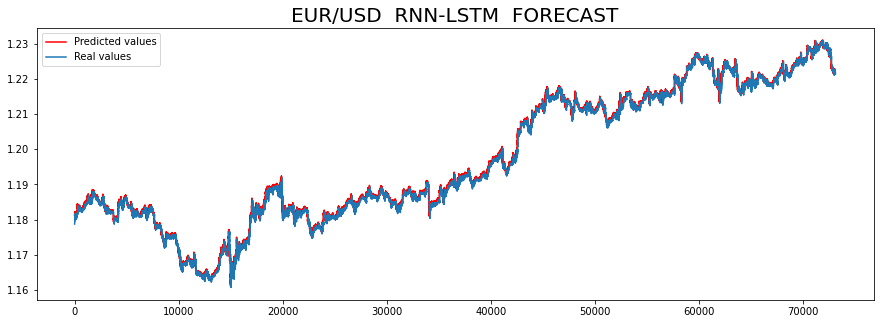

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(prediccion , color='red', label='Predicted values')
plt.plot(test_data.values, label='Real values')
plt.title('EUR/USD  RNN-LSTM  FORECAST', fontsize=20)
plt.legend()
plt.show()